In [4]:
import numpy as np
import networkx as nx
from scipy.linalg import eigvals
import pandas as pd
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
import igraph as ig

def compute_graph_metrics(G):
    """Computes the 30 network metrics from the paper, with necessary normalizations."""
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    degrees = np.array([deg for _, deg in G.degree()])
    max_deg = max(degrees) if len(degrees) > 0 else 1

    metrics = {}

    # 1. ⟨k⟩, density
    metrics["Density (⟨k⟩)"] = nx.density(G)

    # 2. var(k), degree variance, normalized by n-1
    metrics["Degree Variance"] = np.var(nx.density(G))

    # 3. ⟨kn⟩, average neighbor degree, normalized by n-1
    avg_neighbor_degree = np.sum(list(nx.average_neighbor_degree(G)))/(n*(n-1))
    metrics["Average Neighbor Degree (⟨kn⟩)"] = avg_neighbor_degree

    # 4. var(kn), average neighbor degree variance
    metrics["Neighbor Degree Variance"] = np.var(list(nx.average_neighbor_degree(G)))

    # 5. ⟨C⟩, average clustering coefficient
    metrics["Average Clustering Coefficient (⟨C⟩)"] = nx.average_clustering(G)

    # 6. var(C), clustering coefficient variance
    clustering_values = list(nx.clustering(G).values())
    metrics["Clustering Coefficient Variance"] = np.var(clustering_values)

    # 7. r, degree correlation (assortativity)
    metrics["Degree Correlation (r)"] = nx.degree_assortativity_coefficient(G)

    # 8. re = |rmax - rmin |, degree correlation elasticity
    # metrics["Degree Correlation Elasticity (re)"] = np.abs(np.max(degrees) - np.min(degrees))

    # 9–10. ⟨rc⟩: normalized rich club coefficient via 100 rewired graphs
    rich_club_real = nx.rich_club_coefficient(G, normalized=False)
    rich_club_random_sums = {k: 0 for k in rich_club_real.keys()}

    reps = 100
    m = G.number_of_edges()
    successful_reps = 0

    for _ in range(reps):
        G_rewired = G.copy()
        try:
            # Reduced nswap and max_tries to avoid over-constraining
            nx.double_edge_swap(G_rewired, nswap=2 * m, max_tries=10 * m)
            rc_rand = nx.rich_club_coefficient(G_rewired, normalized=False)
            for k in rich_club_real.keys():
                rich_club_random_sums[k] += rc_rand.get(k, 0)
            successful_reps += 1
        except nx.NetworkXAlgorithmError:
            continue  # Skip this iteration if rewire fails

    if successful_reps > 0:
        rich_club_random_avg = {
            k: rich_club_random_sums[k] / successful_reps for k in rich_club_real.keys()
        }
        normalized_rc = []
        for k in rich_club_real:
            denom = rich_club_random_avg.get(k, 0)
            if denom != 0:
                normalized_rc.append(rich_club_real[k] / denom)

        if normalized_rc:
            metrics["Rich Club Metric (⟨rc⟩)"] = np.mean(normalized_rc)
            metrics["Rich Club Variance"] = np.var(normalized_rc)
        else:
            metrics["Rich Club Metric (⟨rc⟩)"] = 0
            metrics["Rich Club Variance"] = 0
    else:
        metrics["Rich Club Metric (⟨rc⟩)"] = 0
        metrics["Rich Club Variance"] = 0


    # 12. |smax - smin|, normalized component size difference
    # connected_components = list(nx.connected_components(G))
    # if connected_components:
    #     largest_cc = max(connected_components, key=len)
    #     smax = len(largest_cc)
    #     smin = min(len(c) for c in connected_components)
    #     metrics["Size Difference (|1 - smin/smax|)"] = np.abs(1 - (smin / smax)) if smax > 0 else 0
    # else:
    #     metrics["Size Difference (|1 - smin/smax|)"] = 0

    # 13. μ, number of modules, normalized by n
    # Convert NetworkX graph to iGraph
    g_ig = ig.Graph.Adjacency((nx.to_numpy_array(G) > 0).tolist())
    g_ig.vs["name"] = list(G.nodes)

    try:
        clusters = g_ig.community_leading_eigenvector()
        μ = len(clusters)
        metrics["Number of Modules (μ)"] = μ / G.number_of_nodes()
    except:
        metrics["Number of Modules (μ)"] = 0



    # 14. ⟨wn⟩, average node betweenness
    node_betweenness = nx.betweenness_centrality(G)
    metrics["Average Node Betweenness (⟨wn⟩)"] = np.mean(list(node_betweenness.values()))


    # 15. var(wn), node betweenness variance
    metrics["Node Betweenness Variance"] = np.var(list(node_betweenness.values()))

    # 16. ⟨we⟩, average edge betweenness
    edge_betweenness = nx.edge_betweenness_centrality(G)
    metrics["Average Edge Betweenness (⟨we⟩)"] = np.mean(list(edge_betweenness.values()))

    # 17. var(we), edge betweenness variance
    metrics["Edge Betweenness Variance"] = np.var(list(edge_betweenness.values()))

    # 18. ⟨cl⟩, average closeness
    closeness = nx.closeness_centrality(G)
    metrics["Average Closeness (⟨cl⟩)"] = np.mean(list(closeness.values()))

    # 19. var(cl), closeness variance
    metrics["Closeness Variance"] = np.var(list(closeness.values()))

    # 20. ⟨l⟩, average path length, normalized by n-1
    if nx.is_connected(G) and n > 1:
        avg_path_length = nx.average_shortest_path_length(G)
        metrics["Average Path Length (⟨l⟩)"] = avg_path_length
    else:
        metrics["Average Path Length (⟨l⟩)"] = 0

    # 21. d, diameter
    if nx.is_connected(G) and n > 1:
        diameter = nx.diameter(G)
        metrics["Diameter (d)"] = diameter / (n - 1)
    else:
        metrics["Diameter (d)"] = 0


    # 22. ⟨dd⟩, distance distribution mean
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    path_lengths = [length for target in shortest_paths.values() for length in target.values()]
    metrics["Distance Distribution Mean (⟨dd⟩)"] = np.mean(path_lengths)

    # 23. var(dd), distance distribution variance
    metrics["Distance Distribution Variance"] = np.var(path_lengths)

    # 24. l3, number of 3-loops (triangles)
    num_triangles = sum(nx.triangles(G).values()) // 3
    if n >= 3:
        total_triples = n * (n - 1) * (n - 2) / 6
        metrics["3-loops (l3)"] = num_triangles / total_triples
    else:
        metrics["3-loops (l3)"] = 0


    # 25. c4, number of 4-cliques
    num_4_cliques = sum(1 for _ in nx.find_cliques(G) if len(_) == 4)
    if n >= 4:
        total_quadruples = n * (n - 1) * (n - 2) * (n - 3) / 24
        metrics["4-Cliques (c4)"] = num_4_cliques / total_quadruples
    else:
        metrics["4-Cliques (c4)"] = 0

    # 26. s4, number of 4-stars normalized by 4-tuples
    num_4_stars = sum((G.degree(node) * (G.degree(node) - 1) * (G.degree(node) - 2)) // 6
                    for node in G.nodes if G.degree(node) >= 3)
    if n >= 4:
        total_quadruples = n * (n - 1) * (n - 2) * (n - 3) / 24
        metrics["4-Stars (s4)"] = num_4_stars / total_quadruples
    else:
        metrics["4-Stars (s4)"] = 0

    # 27. G, graph energy (sum of absolute eigenvalues of adjacency matrix), normalized by n^1.5
    adj_matrix = nx.to_numpy_array(G)
    eigenvalues = np.linalg.eigvals(adj_matrix)
    metrics["Graph Energy (G)"] = np.sum(np.abs(eigenvalues)) / (n ** 1.5)

    # 28. ⟨eC⟩, average eigencentrality
    eigencentrality = nx.eigenvector_centrality_numpy(G)
    metrics["Average EigenCentrality (⟨eC⟩)"] = np.mean(list(eigencentrality.values()))

    # 29. var(eC), eigencentrality variance
    metrics["EigenCentrality Variance"] = np.var(list(eigencentrality.values()))

    # 30. a, algebraic connectivity normalized by (n-1)
    laplacian_matrix = nx.laplacian_matrix(G).todense()
    laplacian_spectrum = np.linalg.eigvalsh(laplacian_matrix)  # safer for symmetric matrices
    if len(laplacian_spectrum) > 1 and n > 1:
        algebraic_connectivity = sorted(laplacian_spectrum)[1]
        metrics["Algebraic Connectivity (a)"] = algebraic_connectivity
    else:
        metrics["Algebraic Connectivity (a)"] = 0

    return metrics

/Users/jianleguo/.pyenv/versions/3.8.18/lib/python3.8/site-packages/igraph/community.py:98: RuntimeWarning: Directed graph supplied, edge directions will be ignored. at src/community/leading_eigenvector.c:393
  membership, _, q = GraphBase.community_leading_eigenvector(graph, clusters, **kwds)
/Users/jianleguo/.pyenv/versions/3.8.18/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/Users/jianleguo/.pyenv/versions/3.8.18/lib/python3.8/site-packages/igraph/community.py:98: RuntimeWarning: ARPACK solver failed to converge (10001 iterations, 0/1 eigenvectors converged) at src/linalg/arpack.c:899
  membership, _, q = GraphBase.community_leading_eigenvector(graph, clusters, **kwds)


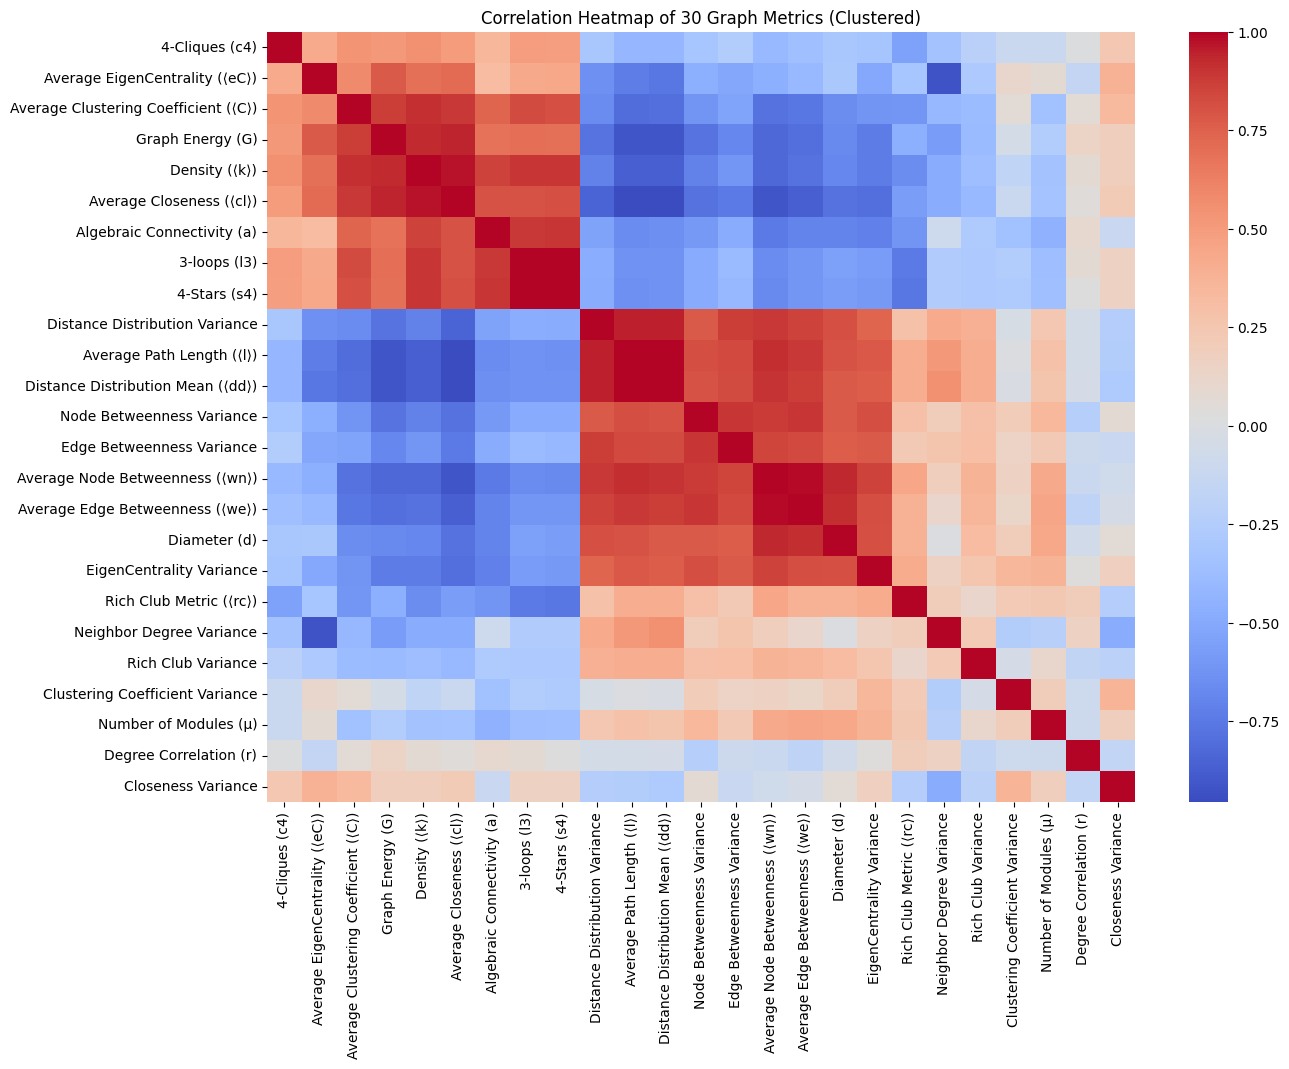

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

unique_graph_hashes = set()

def generate_unique_connected_graph(node=14):
    while True:
        edge_count = int(np.random.pareto(2.5) * 15)
        edge_count = min(max(edge_count, node), node * (node - 1) // 2)
        G = nx.gnm_random_graph(node, edge_count)
        if nx.is_connected(G):
            graph_hash = weisfeiler_lehman_graph_hash(G)
            if graph_hash not in unique_graph_hashes:
                unique_graph_hashes.add(graph_hash)
                return G

def get_graph_structure(G, graph_id):
    adj_matrix = nx.to_numpy_array(G, dtype=int).flatten()
    return {
        "graph_structure": list(adj_matrix),
        "graph_id": graph_id,
        "node_count": len(G.nodes)
    }


# Generate graphs with node counts of 8, 10, 12, and 14, for a total of 40000 graphs
node_counts = [8, 10, 12, 14]
graphs = []

# Generate 10000 graphs for each node count (8, 10, 12, 14)
for node_count in node_counts:
    graphs.extend([generate_unique_connected_graph(node_count) for _ in range(10000)])

# Store graph structures (including adjacency matrix as a list)
data_structure = [get_graph_structure(G, i) for i, G in enumerate(graphs)]

# Create DataFrame from the structures
df_structure = pd.DataFrame(data_structure)

# Compute graph metrics
data = [compute_graph_metrics(G) for G in graphs]
df_metrics = pd.DataFrame(data)

# Remove columns with the same values across all rows (redundant)
df_metrics = df_metrics.loc[:, (df_metrics.nunique() > 1)]

# Merge graph structure with metrics
df_combined = pd.concat([df_metrics, df_structure], axis=1)

# Compute hierarchical clustering of correlation matrix
corr_matrix = df_metrics.corr()
linkage_matrix = linkage(corr_matrix, method="ward")
ordered_cols = leaves_list(linkage_matrix)  # Get reordered indices

# Reorder DataFrame by clustered order
df_metrics = df_metrics.iloc[:, ordered_cols]

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# --- STEP 1: PCA setup ---
df_combined_pca = df_combined.dropna(subset=df_combined.columns.difference(['graph_id', 'graph_structure', 'node_count']))
df_numeric = df_combined_pca.drop(columns=["graph_id", "graph_structure", "node_count"], errors='ignore')
df_real = df_numeric.applymap(lambda x: x.real if isinstance(x, complex) else x)
df_standardized = (df_real - df_real.mean()) / df_real.std()

pca = PCA(n_components=3)
pc_scores = pca.fit_transform(df_standardized)
df_combined_pca["PC1"], df_combined_pca["PC2"] = pc_scores[:, 0], pc_scores[:, 2]
df_combined.loc[df_combined_pca.index, "PC1"] = df_combined_pca["PC1"]
df_combined.loc[df_combined_pca.index, "PC2"] = df_combined_pca["PC2"]

# --- STEP 2 + 3: Per-node-count 3x3 block assignment using min-max box ---
all_output = []

for node_count in [8, 10, 12, 14]:
    subset = df_combined_pca[df_combined_pca["node_count"] == node_count].copy()

    # Use true rectangular bounds
    min_x, max_x = subset["PC1"].min(), subset["PC1"].max()
    min_y, max_y = subset["PC2"].min(), subset["PC2"].max()

    x_edges = np.linspace(min_x, max_x, 4)
    y_edges = np.linspace(min_y, max_y, 4)

    def get_block_id(x, y):
        col = np.digitize([x], x_edges, right=True)[0] - 1
        row = np.digitize([y], y_edges, right=True)[0] - 1
        if 0 <= row < 3 and 0 <= col < 3:
            return int(f"{row * 3 + col + 1}")
        else:
            return None

    # Assign block IDs
    subset["block_id"] = subset.apply(lambda row: get_block_id(row["PC1"], row["PC2"]), axis=1)
    subset = subset.dropna(subset=["block_id"])
    subset["block_id"] = subset["block_id"].astype(int)

    if not subset.empty:
        subset_renamed = subset[["graph_structure", "block_id", "node_count", "PC1", "PC2"]].rename(
            columns={"PC1": "pc_one", "PC2": "pc_two"}
        )
        all_output.append(subset_renamed)


# --- STEP 4: Combine all results ---
df_all_blocks_final = pd.concat(all_output, ignore_index=True)


/var/folders/p0/c1wj7grd6lb721vh0hbl8cq80000gn/T/ipykernel_43321/3889213804.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_pca["PC1"], df_combined_pca["PC2"] = pc_scores[:, 0], pc_scores[:, 2]
/var/folders/p0/c1wj7grd6lb721vh0hbl8cq80000gn/T/ipykernel_43321/3889213804.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_pca["PC1"], df_combined_pca["PC2"] = pc_scores[:, 0], pc_scores[:, 2]


In [7]:
df_all_blocks_final.to_csv('Block_Graph.csv', index=False)